## Building Seq2Seq LSTM with Long Attention in Keras for Time Series Forecasting
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd


Using TensorFlow backend.


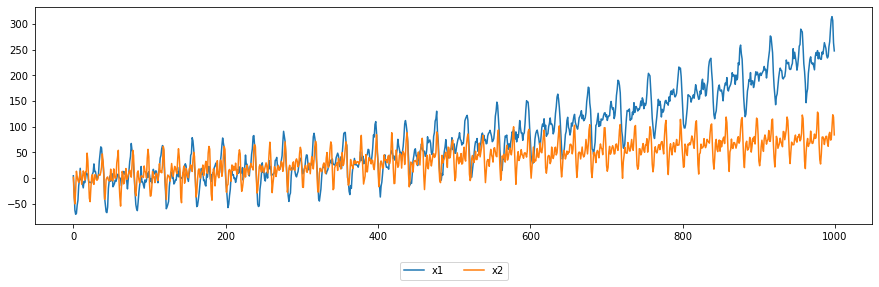

In [2]:
# CREATE Some Data
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)

# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0,6,n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0,6,n_)
plt.figure(figsize=(15,4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [3]:
# PREPROCESS
# Split sequences to 80% train set and 20% test set
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


[ 2.42583267e-04  8.55012575e-03 -2.55024700e+00]
[ 0.08024288 -0.79966692]


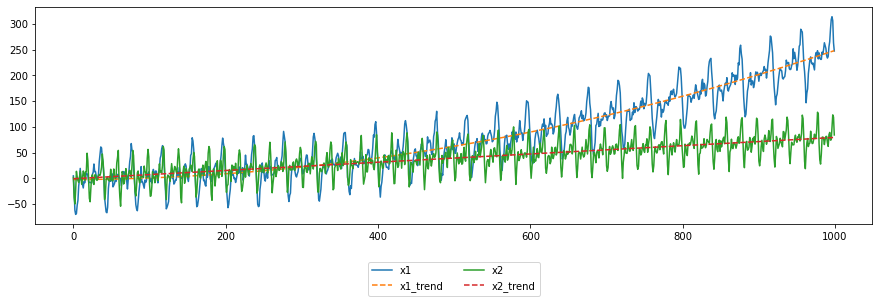

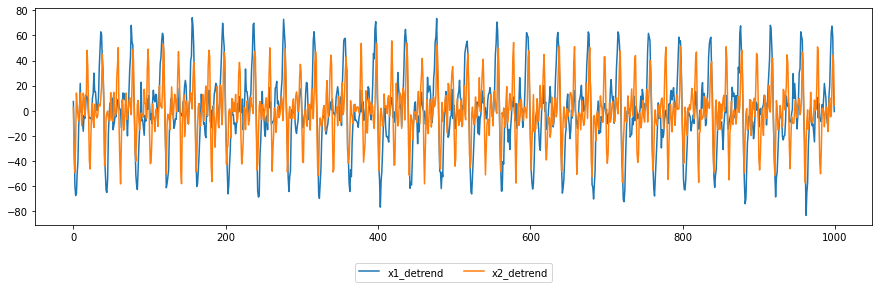

In [4]:
# DETRENDING

x_index = np.array(range(len(t)))

# use np.polyfit to fit the trend lines of first 800 data points 
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

# PLOT the trend
plt.figure(figsize=(15,4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# DEDUCT The trend
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15,4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x1_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()


# aafter remooving the trend, x1 and x2 become stationary

In [5]:
# COMBINE SEQUENCES

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])

print(x_lbl.shape)
print(x_lbl)
# the first column is the detrended x1
# the second column is the detrended x2
# the third column is the index
# the fourth column is the label (1 for the train set and 0 for test set)

(1000, 4)
[[ 7.31376707e+00  2.58761049e+00  0.00000000e+00  1.00000000e+00]
 [-2.14309493e+01 -3.63004430e+01  1.00000000e+00  1.00000000e+00]
 [-5.95719223e+01 -4.92319479e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 5.91792469e+01  4.41194944e+01  9.97000000e+02  0.00000000e+00]
 [ 1.57645363e+01  3.96883054e+01  9.98000000e+02  0.00000000e+00]
 [-6.65599548e-01  4.85316408e+00  9.99000000e+02  0.00000000e+00]]


[74.10833130923272, 55.64979833812168, 1, 1]
[[ 9.86902139e-02  4.64981108e-02  0.00000000e+00  1.00000000e+00]
 [-2.89184076e-01 -6.52301429e-01  1.00000000e+00  1.00000000e+00]
 [-8.03849193e-01 -8.84674328e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.98550526e-01  7.92806007e-01  9.97000000e+02  0.00000000e+00]
 [ 2.12722861e-01  7.13179681e-01  9.98000000e+02  0.00000000e+00]
 [-8.98144023e-03  8.72090147e-02  9.99000000e+02  0.00000000e+00]]


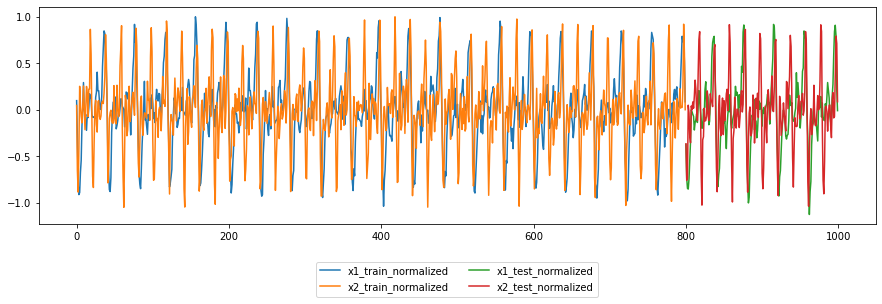

In [6]:
# NORMALIZE to help model void favouring large features while ignoring very small features
# Dividing the corresponding maximum values in train set
x_train_max = x_lbl[x_lbl[:,3]==1, :2].max(axis=0) 
x_train_max = x_train_max.tolist()+[1]*2 #only normalize for the first 2 columns
print(x_train_max)

x_normalize = np.divide(x_lbl,x_train_max)
print(x_normalize)

plt.figure(figsize=(15,4))
plt.plot(range(train_len), x_normalize[:train_len,0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len,1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:,0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:,1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [7]:
# TRUNCAT: cut sequene into smaller pieces by sliding an input window
# INPUT length = 200 timesteps, OUTPUT length = 20 timesteps and put samples in 3D numpy arrays

def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
    

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3),
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

# input to neural network X_in: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: detrended and normalised x1, detrended and normalised x2, and original assigned data position index. Only the first 2 features will be used for training.
# target in neural network X_out: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in X_in. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.
# label lbl: 1 for train set and 0 for test set.

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(781, 200, 3) (781, 20, 3) (781,)
(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


## MODEL 1: Simple Seq2Seq LSTM Model

In [8]:
# The encoder LSTM cell: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.
# The decoder LSTM cell: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

n_hidden = 100 # set hidden layers
# INPUT layers
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

# THE ENCODER LSTM
# return_sequences=False, return_state=False: return the last hidden state: state_h
# return_sequences=True, return_state=False: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
# return_sequences=False, return_state=True: return 3 arrays: state_h, state_h, state_c
# return_sequences=True, return_state=True: return 3 arrays: stacked hidden states, last state_h, last state_c
# For simple Seq2Seq model, we only need last state_h and last state_c.

encoder_last_h1, encoder_last_h2, encoder_last_c =LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_sequences=False, 
    return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

# ADD Batch Normalisation to avoid gradient explosion
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# MAKE 20 copies of the last hidden state of encoder and use them as input to the decoder.
# The last cell state and the last hidden state of the encoder are also used as the initial states of decoder

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)
Tensor("lstm_1/strided_slice_18:0", shape=(None, 100), dtype=float32)
Tensor("lstm_1/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_1/while:5", shape=(None, 100), dtype=float32)
Tensor("lstm_2/transpose_1:0", shape=(None, 20, 100), dtype=float32)
Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [ ]:
# Feed into the model. Set clipnorm=1 for adam optimiser to normalise the gradient to avoid explosion during back propagation

model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

plot_model(model, to_file='seq2se_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# TRAINING
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:,:,:2], X_output_train[:,:,:2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('models\model_forecasting_seq2seq.h5')

plt.plot(train_mae, label='train mae'),
plt.plot(valid_mae, label='valalidation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
# PREDICTION
# Unnormalised output
train_pred_detrend = model.predict(X_input_train[:,:,:2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:,:,:2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:,:,:2]*x_train_max[:2]
test_true_detrend = X_output_test[:,:,:2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)


# Combine the unnormalised outputs with their corresponding inde to recover the trend
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:,:,2],axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:,:,2],axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:,:,2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:,:,2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

In [ ]:
# Put all the outputs with recovered trend into a dictionary data_final
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend],['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:,:,0]+(dt[:,:,2]**2)*x1_trend_param[0]+dt[:,:,2]*x1_trend_param[1]+x1_trend_param[2]
    dt_x2 = dt[:,:,1]+dt[:,:,2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

for lb in ['train','test']:
    plt.figure(figsize=(15,4)) 
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.55, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()
    # The prediction is good  since the distribution of prrediction and true value are almost overlapped

In [ ]:
# Plot MAE to see if there is clear pattern. 
# The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently train
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred']-data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred']-data_final[lb+'_true']).mean(axis=(1,2))
    plt.figure(figsize=(15,3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()
# Based on the plot, there exist certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

In [ ]:
# n-th prediction of each time step

ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15,5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train','test'],[train_start_t, test_start_t], [['green','red'],['blue','orange']]):
    for i, x_lbl in zip([0,1],['x1','x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), data_final[lb+'_pred'][:,ith_timestep,i], linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_true'].shape[0]), data_final[lb+'_true'][:,ith_timestep,i], linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)

plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

# prediction on test set
lb = 'test'
plt.figure(figsize=(15,5))
for i, x_lbl, clr in zip([0,1],['x1','x2'],['green','blue']):
    plt.plot(data_final[lb+'_pred'][:,ith_timestep,i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:,ith_timestep,i], linestyle='-', color=clr, label='true '+x_lbl)

plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Model 2: Seq2Seq LSTM Model with Luong Attention (Multiplicative Attention)

In [ ]:
#  The INPUT layer (same as Model 1)
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

# ENCODER (returning the last hidden state, thhe last cell state, and stacked hidden states for alignment score calculation)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h, encoder_last_h, encoder_last_c)

# Batch normalisation to avoid gradient explosion
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# DECODER (repeat the last hidden state of encoder 20x and use them as input to decoder LSTM)
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

# Stack the hidden state of the decoder for alignment score calculation
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

In [ ]:
# ATTENTION LAYER
# 1. Calculate the alignment score and apply softmax activation function over it
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2,2])
attention = Activation('softmax')(attention)
print(attention)

# 2. Calculate the context vector and batch normalisation
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

# 3. Concatenate the context vector and staccked hidden states of decoder, and use it as input to the last dense layer
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)


In [ ]:
# Model 2
model2 = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.11, clipnorm=1)
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model2.summary()

plot_model(model2, to_file='seq2se_attention_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# TRAINING
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model2.fit(X_input_train[:,:,:2], X_output_train[:,:,:2], validation_split=0.2,
                    epochs=epc, verbose=1, callbacks=[es],batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model2.save('models\model_forecasting_seq2seq_attention.h5')

plt.plot(train_mae, label='train mae'),
plt.plot(valid_mae, label='valalidation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred']-data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred']-data_final[lb+'_true']).mean(axis=(1,2))
    plt.figure(figsize=(15,3))
    plt.plot(MAE_)
    plt.title('MAE '+lb)